In [1]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import lars_path

%matplotlib inline
sns.set()

import warnings
warnings.simplefilter("ignore")

In [2]:
with open('../feature_engineering/video_channel_df_8162_fin.pkl', 'rb') as picklefile:
    df = pickle.load(picklefile)

In [3]:
df.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name'],
      dtype='object')

In [4]:
X_array = df.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df = df[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y = df['views_video']

## Baseline linear regression

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

vanilla_LR = LinearRegression()
vanilla_LR.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
vanilla_LR.score(X_train,y_train) 

0.9597382729266982

In [7]:
vanilla_LR.score(X_test,y_test)

0.7475116440993992

## Study Influence of Outliers on Best Model

In [8]:
df['res'] = abs(vanilla_LR.predict(X_df)-df['views_video'])

In [9]:
df['res'].describe()

count    8.162000e+03
mean     2.197852e+05
std      1.230999e+06
min      2.785025e+01
25%      3.631629e+04
50%      7.971599e+04
75%      1.460839e+05
max      5.814060e+07
Name: res, dtype: float64

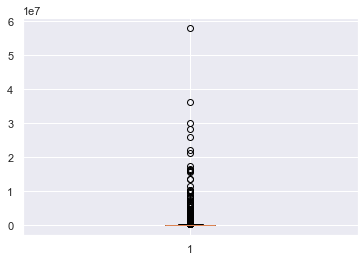

In [10]:
plt.boxplot(df['res']);

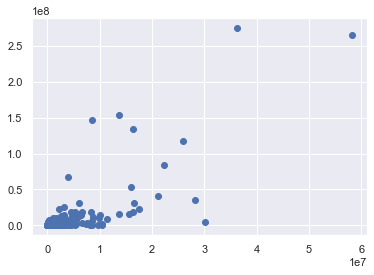

In [11]:
plt.scatter(df['res'], df['views_video']);

In [12]:
#outliers in terms of residuals
df[df['res'] > 1.233987e+05]

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,
c8RrUCDu6RU,10874.0,21.0,2100.0,15.0,1.0,574.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,1645.0,0,1,11.0,-2.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,133336.452127
-U5LaNdDVO4,10134.0,22.0,2700.0,19.0,0.0,1111.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,1659.0,0,1,11.0,1.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,147778.723871
cRkp5_w9JLM,21721.0,9.0,444.0,667.0,0.0,513.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,637.0,1,0,11.0,17.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,552764.319120
2bmF9Ms2ihI,812210.0,4.0,2520.0,140.0,2.0,810.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,306.0,1,0,11.0,8.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,611138.701781
Ys84hYfrRmw,62235.0,24.0,759.0,76.0,2.0,981.0,3070.0,237924.0,0.0,2.0,288.0,4426.0,1835.0,1,0,11.0,11.0,https://www.youtube.com/user/oceanworshipper,Donate to EcoKarma,134105.193701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q3MiLWxo1Jc,66972.0,18.0,43200.0,94.0,10.0,3345.0,659000.0,207880503.0,0.0,0.0,0.0,5047.0,19.0,1,0,0.0,23.0,https://www.youtube.com/user/yogayak,,235336.891249
kYVXSQaF1n0,136991.0,13.0,43200.0,128.0,11.0,3307.0,659000.0,207880503.0,0.0,0.0,0.0,5047.0,14.0,1,0,0.0,19.0,https://www.youtube.com/user/yogayak,,235528.953731
h6BlCAs6LgU,65901.0,2.0,43200.0,118.0,3.0,3162.0,659000.0,207880503.0,0.0,0.0,0.0,5047.0,2.0,1,0,0.0,16.0,https://www.youtube.com/user/yogayak,,197297.504292


In [13]:
#df[df['res'].max()]
#58140600.89979908
max_r = df[df['res']==58140600.89979908]
print(str(max_r['channel_URL']))

video_id
2Z3DC7RLjfY    https://www.youtube.com/channel/UC4dlco6FzS-AJ...
Name: channel_URL, dtype: object


In [14]:
np.array(X_df.loc['2Z3DC7RLjfY',:].values)

array([2.0000000e+00, 2.0000000e+02, 1.6504500e+05, 7.1010000e+03,
       2.9790000e+03, 0.0000000e+00, 2.9174939e+07, 0.0000000e+00,
       0.0000000e+00, 2.6100000e+02, 6.4400000e+02, 3.8100000e+02,
       1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 9.0000000e+00])

In [15]:
vanilla_LR.predict(np.array(X_df.loc['2Z3DC7RLjfY',:].values).reshape(1, -1))

array([2.0732306e+08])

In [16]:
#df[df['res'].min()]
#58140600.89979908
max_r = df[df['res']<28]
#print(str(max_r['channel_URL']))
max_r

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,channel_URL,channel_name,res
video_id,,,,,,,,,,,,,,,,,,,,
FkLz8Xe7pn4,2033.0,12.0,51.0,2.0,0.0,351.0,0.0,115252.0,0.0,8.0,592.0,2109.0,1266.0,1,0,12.0,4.0,https://www.youtube.com/channel/UCwCBAbstJ5VNv...,Yoga for Men,27.850251


In [17]:
vanilla_LR.predict(np.array(X_df.loc['FkLz8Xe7pn4',:].values).reshape(1, -1))

array([2005.14974892])

In [18]:
df_no_outliers = df[df['res'] < 1.233987e+05]  ## keep 6

In [19]:
df_no_outliers.shape ##removed 2573 observations with greatest residual values 

(5589, 20)

In [20]:
X_array_no_outliers = df_no_outliers.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df_no_outliers = df_no_outliers[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y_no_outliers = df_no_outliers['views_video']

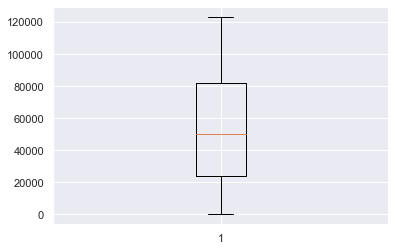

In [21]:
plt.boxplot(df_no_outliers['res']);

In [22]:
round(df_no_outliers.describe())

,views_video,video_order_num,duration_sec,likes,dislikes,video_desc_length,subscriber_count,total_views_channel,n_featured_channels,n_promo_links,channel_desc_length,channel_age_days,video_age_days,delivery_method_Published,delivery_method_Streamed live,sentiment_score_channel_desc,sentiment_score_video_desc,res
count,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0,5589.0
mean,25689.0,13.0,894.0,45.0,1.0,682.0,18244.0,2586366.0,1.0,4.0,400.0,2032.0,502.0,1.0,0.0,6.0,6.0,54200.0
std,94977.0,8.0,1714.0,99.0,5.0,815.0,53686.0,15096014.0,2.0,4.0,352.0,1194.0,558.0,0.0,0.0,8.0,11.0,34671.0
min,1.0,1.0,3.0,0.0,0.0,0.0,0.0,182.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,-7.0,-41.0,28.0
25%,1471.0,6.0,60.0,3.0,0.0,115.0,1030.0,89906.0,0.0,0.0,28.0,1042.0,35.0,1.0,0.0,0.0,0.0,24119.0
50%,6332.0,12.0,356.0,13.0,0.0,401.0,2740.0,326204.0,0.0,2.0,323.0,1910.0,253.0,1.0,0.0,3.0,2.0,50166.0
75%,21518.0,19.0,1080.0,44.0,1.0,921.0,13100.0,1224804.0,0.0,7.0,742.0,2756.0,893.0,1.0,0.0,10.0,9.0,82302.0
max,4338084.0,30.0,43200.0,2440.0,203.0,4897.0,798000.0,525487655.0,10.0,16.0,1000.0,5297.0,3136.0,1.0,1.0,41.0,162.0,123359.0


## Baseline Regression with Outliers Removed

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_df_no_outliers, 
                                                    y_no_outliers, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [24]:
vanilla_LR_no = LinearRegression()
vanilla_LR_no.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
vanilla_LR_no.score(X_train,y_train) #--> outliers

0.9068768699977708

In [26]:
vanilla_LR_no.score(X_test,y_test)

0.6294751526179592

## Regularizing, keeping Original Features

In [27]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [28]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [29]:
lasso_model.score(X_tr,y_train)

0.9067556235835056

In [30]:
lasso_model.alpha_

77.52597488629465

In [31]:
lasso_model.score(X_te,y_test) ##doesnt work as it is about variation in the data, 

0.6290198539565494

## Adding Channel Level Aggrigative Features

In [32]:
df_channel_video_history = (df_no_outliers
 .groupby(['channel_URL'])[['views_video', 'video_order_num', 'video_desc_length', 
                            'likes', 'dislikes', 'duration_sec', 
                            'video_age_days', 'sentiment_score_video_desc']]
 .agg({
     'views_video':'mean',
     'video_order_num':'count',
     'video_desc_length': 'mean',
     'likes':'sum',
     'dislikes':'sum',
     'duration_sec':'mean',
     'video_age_days':'mean',
     'sentiment_score_video_desc':'mean'
     
 })
)

In [33]:
df_no_outliers = df_no_outliers.join(df_channel_video_history, on='channel_URL', how='left', rsuffix='_history')

In [34]:
df_no_outliers.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res',
       'views_video_history', 'video_order_num_history',
       'video_desc_length_history', 'likes_history', 'dislikes_history',
       'duration_sec_history', 'video_age_days_history',
       'sentiment_score_video_desc_history'],
      dtype='object')

In [35]:
df_no_outliers.rename(columns={'views_video_history':'views_video_hist_mean',
                   'video_order_num_history':'video_order_num_hist_count',
                   'video_desc_length_history':'video_desc_length_hist_mean', 
                   'likes_history':'likes_hist_sum', 
                   'dislikes_history':'dislikes_hist_sum',
                   'duration_sec_history':'duration_sec_hist_mean', 
                   'video_age_days_history':'video_age_days_hist_mean',
                   'sentiment_score_video_desc_history':'sentiment_score_video_desc_hist_mean'}, 
          inplace=True)

In [36]:
df_no_outliers.columns

Index(['views_video', 'video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc', 'channel_URL', 'channel_name', 'res',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean'],
      dtype='object')

## Add polynomial and interaction terms 

In [37]:
X_array_h = df_no_outliers.loc[:,['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h = df_no_outliers[['video_order_num', 'duration_sec', 'likes', 'dislikes',
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h = df_no_outliers['views_video']

In [38]:
pf = PolynomialFeatures(degree=2)
orig_features_h = X_df_h.columns
pf.fit(df_no_outliers[orig_features_h])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [39]:
feat_array_h = pf.transform(df_no_outliers[orig_features_h])
feat_array_h = pd.DataFrame(feat_array_h, columns = pf.get_feature_names(input_features=orig_features_h))

In [40]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h, y_h, 
                                                    test_size=0.3, 
                                                    random_state=42)
model_w_poly_feat_h = LinearRegression()
model_w_poly_feat_h.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [41]:
model_w_poly_feat_h.score(X_train,y_train)

0.969861153992098

In [42]:
model_w_poly_feat_h.score(X_test,y_test) #overfit alert! regularize

0.7581980182699333

In [43]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-10,10,200)
lasso_model_w_poly_feat_h = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h.fit(X_tr, y_train);

In [44]:
lasso_model_w_poly_feat_h.score(X_tr,y_train) ##note:ridge gives slightly worse result

0.9589580705171986

In [45]:
lasso_model_w_poly_feat_h.alpha_

580.5225516094907

In [46]:
lasso_model_w_poly_feat_h.score(X_te,y_test)

0.7979397733493132

In [47]:
coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [49]:
df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
df_coefs

,variable,coefficient
0,1,0.000000
1,video_order_num,-0.000000
2,duration_sec,-0.000000
3,likes,13295.319761
4,dislikes,4625.622935
...,...,...
320,duration_sec_hist_mean video_age_days_hist_mean,-0.000000
321,duration_sec_hist_mean sentiment_score_video_d...,-0.000000
322,video_age_days_hist_mean^2,-0.000000
323,video_age_days_hist_mean sentiment_score_video...,-0.000000


In [50]:
df_coefs[df_coefs['coefficient']>0.0]

,variable,coefficient
3,likes,13295.319761
4,dislikes,4625.622935
17,views_video_hist_mean,12693.248834
29,video_order_num video_desc_length,1218.914557
50,duration_sec likes,2629.156653
72,likes^2,9265.330637
77,likes n_featured_channels,2.483314
80,likes channel_age_days,2182.129818
81,likes video_age_days,26155.668401
82,likes delivery_method_Published,4073.094820


In [51]:
#95, 74 --> #99,77

In [52]:
test_set_pred = lasso_model_w_poly_feat_h.predict(X_te)

In [53]:
#mae
np.mean(np.abs(test_set_pred - y_test))

11712.237203148024

## Model2: Remove variables that we do not have for new video

Inspect

In [54]:
df_nolidisl = df_no_outliers.drop(['likes', 'dislikes','channel_URL', 'channel_name'], axis=1)

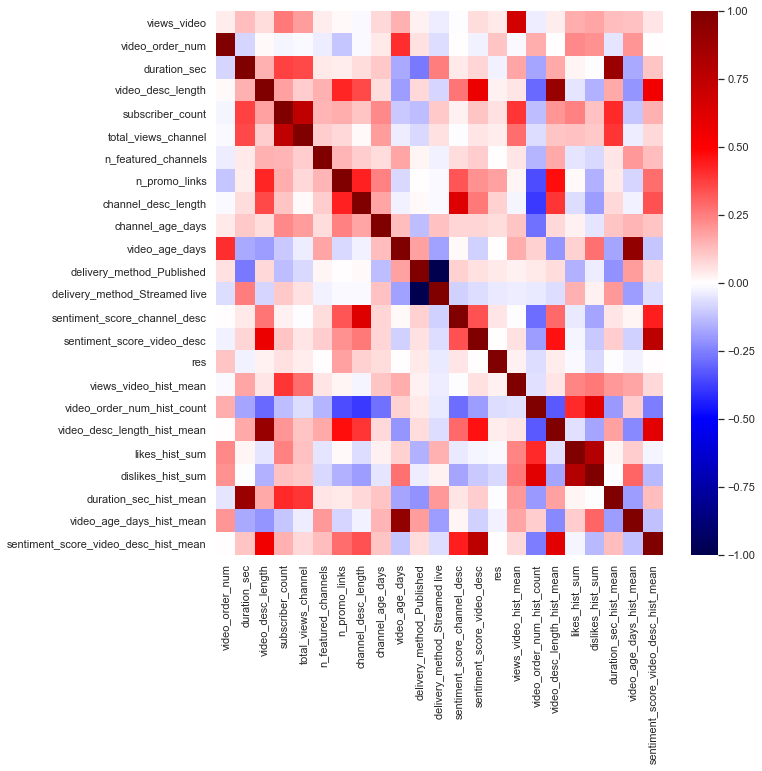

In [55]:
plt.figure(figsize=[10,10])
sns.heatmap(df_nolidisl.corr(), square=False, cmap="seismic", annot=False,  vmin=-1, vmax=1)
plt.gca().set_xlim(1);

Model

In [56]:
X_array_no_outliers = df_no_outliers.loc[:,'video_order_num':'sentiment_score_video_desc'].values.reshape(-1, 1)
X_df_no_outliers = df_no_outliers[['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc']]
y_no_outliers = df_no_outliers['views_video']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_df_no_outliers, 
                                                    y_no_outliers, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [58]:
vanilla_LR_no = LinearRegression()
vanilla_LR_no.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
vanilla_LR_no.score(X_train,y_train) #--> outliers

0.12118359548189472

In [60]:
vanilla_LR_no.score(X_test,y_test)

0.12872661784780726

## Regularizing, keeping Original Features

In [61]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray

In [62]:
alphavec = 10**np.linspace(-6,4,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train);

In [63]:
lasso_model.score(X_tr,y_train)

0.12118359548189495

In [64]:
lasso_model.alpha_

1e-06

In [65]:
lasso_model.score(X_te,y_test) ##doesnt work as it is about variation in the data, 

0.12872661794575446

In [66]:
#removing likes and dislikes
X_array_h_rem_likes = df_no_outliers.loc[:,['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']].values.reshape(-1, 1)

X_df_h_rem_likes = df_no_outliers[['video_order_num', 'duration_sec', 
       'video_desc_length', 'subscriber_count', 'total_views_channel',
       'n_featured_channels', 'n_promo_links', 'channel_desc_length',
       'channel_age_days', 'video_age_days', 'delivery_method_Published',
       'delivery_method_Streamed live', 'sentiment_score_channel_desc',
       'sentiment_score_video_desc',
       'views_video_hist_mean', 'video_order_num_hist_count',
       'video_desc_length_hist_mean', 'likes_hist_sum', 'dislikes_hist_sum',
       'duration_sec_hist_mean', 'video_age_days_hist_mean',
       'sentiment_score_video_desc_hist_mean']]

y_h_rem_likes = df_no_outliers['views_video']

In [67]:
pf = PolynomialFeatures(degree=2)
orig_features_h_rem_likes = X_df_h_rem_likes.columns
pf.fit(df_no_outliers[orig_features_h_rem_likes])

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [68]:
feat_array_h_rem_likes = pf.transform(df_no_outliers[orig_features_h_rem_likes])
feat_array_h_rem_likes = pd.DataFrame(feat_array_h_rem_likes, columns = pf.get_feature_names(input_features=orig_features_h_rem_likes))

In [69]:
X_train, X_test, y_train, y_test = train_test_split(feat_array_h_rem_likes, y_h_rem_likes, 
                                                    test_size=0.3, 
                                                    random_state=42)
model_w_poly_feat_h_rem_likes = LinearRegression()
model_w_poly_feat_h_rem_likes.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
model_w_poly_feat_h_rem_likes.score(X_train,y_train)

0.8382687782537948

In [71]:
model_w_poly_feat_h_rem_likes.score(X_test,y_test) #overfit alert! regularize

0.373327967812396

In [72]:
std = StandardScaler()
std.fit(X_train)
X_tr = std.transform(X_train)
X_te = std.transform(X_test)#numpy.ndarray
alphavec = 10**np.linspace(-10,10,200)
lasso_model_w_poly_feat_h_rem_likes = LassoCV(alphas = alphavec, cv=5)
lasso_model_w_poly_feat_h_rem_likes.fit(X_tr, y_train);

In [73]:
lasso_model_w_poly_feat_h_rem_likes.score(X_tr,y_train) 

0.803692765709135

In [74]:
lasso_model_w_poly_feat_h_rem_likes.alpha_

731.6807143427208

In [75]:
lasso_model_w_poly_feat_h_rem_likes.score(X_te,y_test)

0.47110730984093935

In [76]:
#coefs = list(zip(X_train.columns, lasso_model_w_poly_feat_h.coef_))

In [77]:
#df_coefs = pd.DataFrame(coefs, columns=['variable', 'coefficient'])
#df_coefs

In [78]:
#df_coefs[df_coefs['coefficient']>0.0]

Conclusion: removing outliers help to boost results a little, but it does not influence the fact of insufficient information; one cannot predict views without likes/dislikes or other features. 

## Visualizing Results

In [79]:
scores_full_no_out = {'baseline':[0.9068768699977708, 0.6294751526179592], 'baseline-lasso':[0.9067556235835056, 0.6290198539565494], 'added-features':[0.969861153992098, 0.7581980182699333], 'added-features-lasso': [0.9589580705171986, 0.7979397733493132] }
scores_full_no_out_no_likes = {'baseline':[0.12118359548189472, 0.12872661784780726], 'baseline-lasso':[0.12118359548189495, 0.12872661794575446], 'added-features':[0.8382687782537948, 0.373327967812396], 'added-features-lasso': [0.803692765709135, 0.47110730984093935] }

In [80]:
scores_full_no_out_df = pd.DataFrame.from_dict(scores_full_no_out).T.reset_index()
scores_full_no_out_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)
scores_full_no_out_no_likes_df = pd.DataFrame.from_dict(scores_full_no_out_no_likes).T.reset_index()
scores_full_no_out_no_likes_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)

In [81]:
scores_full = {'baseline':[0.9597382729266982, 0.7475116440993992], 'baseline-lasso':[0.9596720678574545, 0.7487661708655377], 'added-features':[0.9965608803465577, -2.2976078488820093], 'added-features-lasso': [0.9892881419367454, 0.7735661621041386] }
scores_no_likes = {'baseline':[0.47071838197885274, -0.5545173252566922], 'baseline-lasso':[0.4703677315816639, -0.5137389688002472], 'added-features':[0.671638781800988, -9.499030390134314], 'added-features-lasso': [0.46571963880441947, -0.5137389688002472] }

In [82]:
scores_full_df = pd.DataFrame.from_dict(scores_full).T.reset_index()
scores_full_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)
scores_no_likes_df = pd.DataFrame.from_dict(scores_no_likes).T.reset_index()
scores_no_likes_df.rename(columns={0:'R2_train', 1:'R2_test', 'index':'model'}, inplace=True)

In [83]:
scores_full_no_out_df

,model,R2_train,R2_test
0,baseline,0.906877,0.629475
1,baseline-lasso,0.906756,0.629020
2,added-features,0.969861,0.758198
3,added-features-lasso,0.958958,0.797940


In [84]:
full = scores_full_df.join(scores_full_no_out_df, rsuffix='_no_out')
full

,model,R2_train,R2_test,model_no_out,R2_train_no_out,R2_test_no_out
0,baseline,0.959738,0.747512,baseline,0.906877,0.629475
1,baseline-lasso,0.959672,0.748766,baseline-lasso,0.906756,0.629020
2,added-features,0.996561,-2.297608,added-features,0.969861,0.758198
3,added-features-lasso,0.989288,0.773566,added-features-lasso,0.958958,0.797940


In [85]:
scores_full_no_out_no_likes_df

,model,R2_train,R2_test
0,baseline,0.121184,0.128727
1,baseline-lasso,0.121184,0.128727
2,added-features,0.838269,0.373328
3,added-features-lasso,0.803693,0.471107


In [86]:
full.rename(columns={'R2_train':'R2 Train', 'R2_test':'R2 Test', 
                     'R2_train_no_out':'R2 Train No Outliers', 'R2_test_no_out':'R2 Test No Outliers'}, inplace=True)

In [87]:
full

,model,R2 Train,R2 Test,model_no_out,R2 Train No Outliers,R2 Test No Outliers
0,baseline,0.959738,0.747512,baseline,0.906877,0.629475
1,baseline-lasso,0.959672,0.748766,baseline-lasso,0.906756,0.629020
2,added-features,0.996561,-2.297608,added-features,0.969861,0.758198
3,added-features-lasso,0.989288,0.773566,added-features-lasso,0.958958,0.797940


In [88]:
#full = full.drop(['model_no_out'], axis=1)
full

,model,R2 Train,R2 Test,model_no_out,R2 Train No Outliers,R2 Test No Outliers
0,baseline,0.959738,0.747512,baseline,0.906877,0.629475
1,baseline-lasso,0.959672,0.748766,baseline-lasso,0.906756,0.629020
2,added-features,0.996561,-2.297608,added-features,0.969861,0.758198
3,added-features-lasso,0.989288,0.773566,added-features-lasso,0.958958,0.797940


In [89]:
full = full.set_index('model')

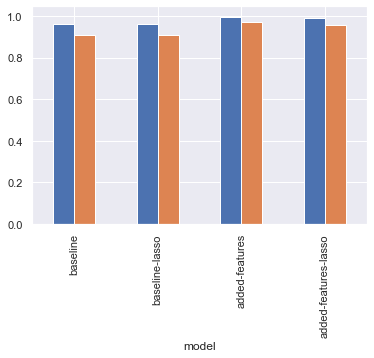

In [90]:
full.loc[:,['R2 Train', 'R2 Train No Outliers']].plot.bar(legend=False);

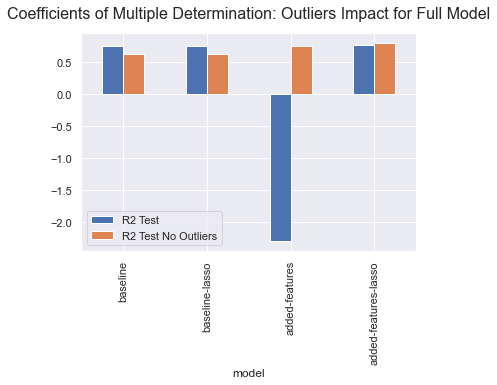

In [91]:
full.loc[:,['R2 Test', 'R2 Test No Outliers']].plot.bar()
plt.title('Coefficients of Multiple Determination: Outliers Impact for Full Model', fontsize=16, pad=15);

In [92]:
no_likes = scores_no_likes_df.join(scores_full_no_out_no_likes_df, rsuffix='_no_out')
no_likes

,model,R2_train,R2_test,model_no_out,R2_train_no_out,R2_test_no_out
0,baseline,0.470718,-0.554517,baseline,0.121184,0.128727
1,baseline-lasso,0.470368,-0.513739,baseline-lasso,0.121184,0.128727
2,added-features,0.671639,-9.499030,added-features,0.838269,0.373328
3,added-features-lasso,0.465720,-0.513739,added-features-lasso,0.803693,0.471107


In [93]:
no_likes.rename(columns={'R2_train':'R2 Train', 'R2_test':'R2 Test', 
                     'R2_train_no_out':'R2 Train No Outliers', 'R2_test_no_out':'R2 Test No Outliers'}, inplace=True)

In [94]:
no_likes

,model,R2 Train,R2 Test,model_no_out,R2 Train No Outliers,R2 Test No Outliers
0,baseline,0.470718,-0.554517,baseline,0.121184,0.128727
1,baseline-lasso,0.470368,-0.513739,baseline-lasso,0.121184,0.128727
2,added-features,0.671639,-9.499030,added-features,0.838269,0.373328
3,added-features-lasso,0.465720,-0.513739,added-features-lasso,0.803693,0.471107


In [95]:
no_likes = no_likes.drop(['model_no_out'], axis=1)

In [96]:
no_likes = no_likes.set_index('model')

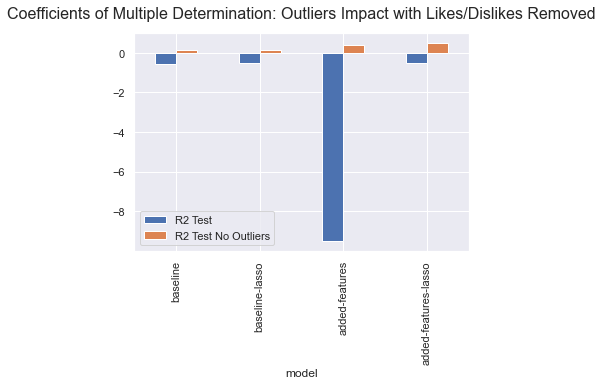

In [97]:
no_likes.loc[:,['R2 Test', 'R2 Test No Outliers']].plot.bar()
plt.title('Coefficients of Multiple Determination: Outliers Impact with Likes/Dislikes Removed', fontsize=16, pad=15);